<a href="https://colab.research.google.com/github/RajanikaD/Brain-Tumor-Detection.ipynb/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imutils

In [2]:
import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
image_dir = '/content/brain_tumor_dataset'

In [4]:
os.makedirs('../output/kaggle/working/augmented-images')
os.makedirs('../output/kaggle/working/augmented-images/yes')
os.makedirs('../output/kaggle/working/augmented-images/no')

In [7]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [10]:
augmented_data_path ='../output/kaggle/working/augmented-images/'

augment_data(file_dir='/content/brain_tumor_dataset/yes',n_generated_samples=6, save_to_dir=augmented_data_path+'yes')

augment_data(file_dir='/content/brain_tumor_dataset/no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')

# Data Preprocessing

In [11]:
def crop_brain_contour(image, plot=False):
    
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

   
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
   
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

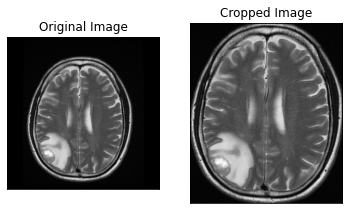

In [13]:
ex_img = cv2.imread('/content/brain_tumor_dataset/yes/Y107.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [14]:
def load_data(dir_list, image_size):

    
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [15]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2064
X shape is: (2064, 240, 240, 3)
y shape is: (2064, 1)


# Visualization

In [16]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

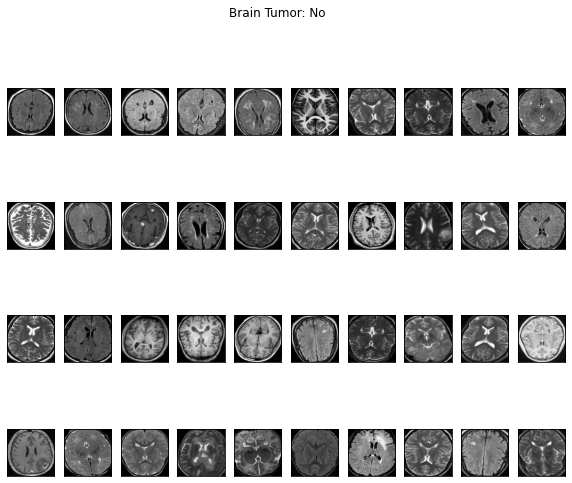

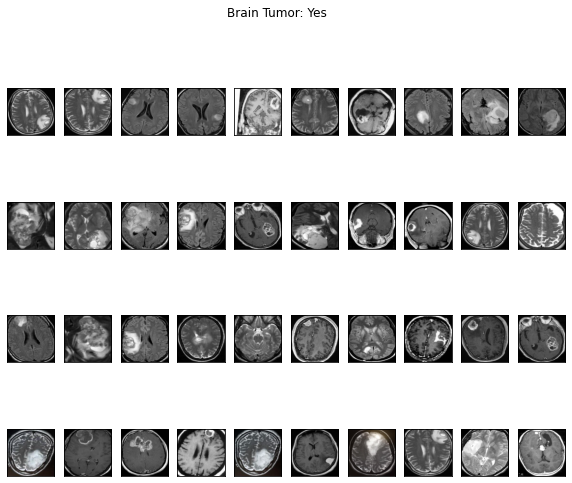

In [17]:
plot_sample_images(X, y)

In [18]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [19]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [20]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1444
number of validation examples = 310
number of test examples = 310


In [21]:
def build_model(input_shape):
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    
    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    
    X = MaxPooling2D((4, 4))(X) 
    X = MaxPooling2D((4, 4))(X) 
    X = Flatten()(X) 
    X = Dense(1, activation='sigmoid')(X) 
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [22]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                           

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))

Epoch 1/22
46/46 [==============================] - 128s 3s/step - loss: 0.8129 - accuracy: 0.6399 - val_loss: 0.6460 - val_accuracy: 0.6613
Epoch 2/22
46/46 [==============================] - 125s 3s/step - loss: 0.4924 - accuracy: 0.7583 - val_loss: 0.5923 - val_accuracy: 0.7226
Epoch 3/22
46/46 [==============================] - 126s 3s/step - loss: 0.4784 - accuracy: 0.7770 - val_loss: 0.6377 - val_accuracy: 0.5806
Epoch 4/22
46/46 [==============================] - 126s 3s/step - loss: 0.4719 - accuracy: 0.7916 - val_loss: 0.5093 - val_accuracy: 0.7903
Epoch 5/22
46/46 [==============================] - 127s 3s/step - loss: 0.3577 - accuracy: 0.8497 - val_loss: 0.5382 - val_accuracy: 0.7000
Epoch 6/22
46/46 [==============================] - 125s 3s/step - loss: 0.3147 - accuracy: 0.8726 - val_loss: 0.5616 - val_accuracy: 0.6839
Epoch 7/22
46/46 [==============================] - 125s 3s/step - loss: 0.2902 - accuracy: 0.8816 - val_loss: 0.4025 - val_accuracy: 0.8355
Epoch 8/22
46

In [24]:
history = model.history.history

# Accuracy

In [25]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

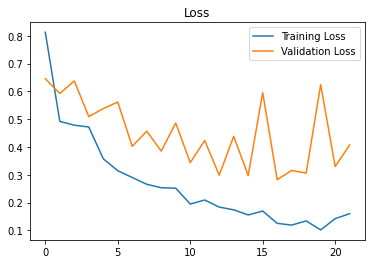

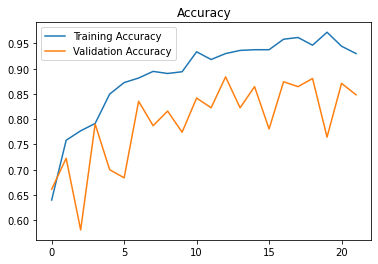

In [26]:
plot_metrics(history)